# TensorFlow Network finding

This notebook will work finding the best trade-off for TensorFlow neural network, using previous data transformation

**Main goals are**:
- Use our understanding of deep learning made during the project
- Learn TensorFlow framework



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/IllnessRecognition/app/dl


/content/drive/MyDrive/IllnessRecognition/app/dl


In [8]:
%ls

batchLogerCallback.py      manualNetworkAdvanced.ipynb  tensorflowNetworkFinding.ipynb
dataAnalysis.ipynb         manualNetworkFinding.ipynb   xray_model.keras
imageImportanceArea.ipynb  __pycache__/
local_lib/                 scalerPcaStudy.ipynb


In [9]:
IMAGE_SIZE = [163, 220]

In [10]:
from local_lib.dataset import retreiveDatasetFromCsv
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from local_lib.non_zero_transformer import NonZeroTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
import numpy as np
from sklearn.preprocessing import MinMaxScaler


dataset = retreiveDatasetFromCsv()
dataset = dataset.sample(frac=1, random_state=42)

Based on the results we had during the machine learning part of the project, we are going yo use this pipeline with the masks, the threshold mecanism and a MinMaxScaler

In [11]:
pipeline = Pipeline([
    ('non_zero_tr', NonZeroTransformer()),
    ('mask_tr', MaskSeuilTransformer(strategy="combined")),
    ('minmax', MinMaxScaler())
    ])

In [12]:
# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))


In [13]:
import copy

# Make a copy of the list
y_simpler = copy.deepcopy(y)
y_simpler[y_simpler == 2] = 1
np.unique(y_simpler)

y = y_simpler

In [14]:
import keras
from tensorflow.keras.callbacks import Callback

class BatchLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_acc = []
        self.epoch_acc = []
        self.epoch_val_acc = []
        self.batch_losses = []
        self.batch_precision = []
        self.batch_recall = []
        self.logs = []

    def on_batch_end(self, batch, logs=None):
        self.batch_acc.append(logs.get('binary_accuracy'))
        self.batch_losses.append(logs.get('loss'))
        self.batch_precision.append(logs.get('precision'))
        self.batch_recall.append(logs.get('recall'))
        self.logs.append(logs)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_acc.append(logs.get('binary_accuracy'))
        self.epoch_val_acc.append(logs.get('val_accuracy'))

checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

batch_loss_logger = BatchLogger()


In [32]:
initial_learning_rate = 0.010
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [16]:
METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        ]

In [17]:
#Reshape to 2D
X_reshaped = X.reshape((X.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

In [18]:
X_reshaped.shape

(5856, 163, 220, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


In [20]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.Conv2D(16, 3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dense(512, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.7),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),
    #layers.Dropout(0.3),

    layers.Dense(1, activation="sigmoid")
])

In [29]:
import tensorflow as tf

# Compile the model with the learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy', metrics=METRICS)

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def fitModelAndPlot(model,X_train,y_train, X_test, y_test, nb_epochs = 10, batch_size = 32, validation_split_percentage = 0.2, useClassWeights = False, useDataGeneration = False):
    if useClassWeights:
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight_dict = dict(enumerate(class_weights))
        history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                            validation_split=validation_split_percentage, callbacks=[checkpoint_cb, early_stopping_cb, batch_loss_logger],
                            class_weight=class_weight_dict)
    elif useDataGeneration:
      datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
      )

      train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
      history = model.fit(train_generator, epochs=nb_epochs, validation_data=(X_test, y_test),
                callbacks=[checkpoint_cb, early_stopping_cb])
    else:
        history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size,
                            validation_split=validation_split_percentage, callbacks=[checkpoint_cb, early_stopping_cb, batch_loss_logger])

    test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc}, Test Loss: {test_loss}, Test Recall: {test_recall}, Test Precision: {test_precision}")

    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 14))

    nb_rows = 5

    plt.subplot(nb_rows, 2, 1)
    plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(nb_rows, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(nb_rows, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(nb_rows, 2, 4)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='best')

    plt.subplot(nb_rows, 2, 5)
    plt.plot(batch_loss_logger.batch_losses, label='Batch Loss')
    plt.title('Batch Loss During Training')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.subplot(nb_rows, 2, 6)
    plt.plot(batch_loss_logger.batch_acc, label='Batch Accuracy')
    plt.title('Batch Accuracy During Training')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(nb_rows, 2, 7)
    plt.plot(batch_loss_logger.batch_precision, label='Batch Precision')
    plt.title('Batch Precision Training')
    plt.xlabel('Batch')
    plt.ylabel('Precision')
    plt.legend(loc='best')

    plt.subplot(nb_rows, 2, 8)
    plt.plot(batch_loss_logger.batch_recall, label='Batch Recall')
    plt.title('Batch Recall Training')
    plt.xlabel('Batch')
    plt.ylabel('Recall')
    plt.legend(loc='best')

    plt.subplot(nb_rows, 2, 9)
    plt.plot(batch_loss_logger.epoch_acc, label='Epoch Accuracy and Validation Accuracy')
    plt.plot(batch_loss_logger.epoch_val_acc, label='Epoch Validation Accuracy')
    plt.title('Epoch Accuracy and Validation Accuracy Training')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy and Validation Accuracy')
    plt.legend(loc='best')

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')


    plt.tight_layout()
    plt.show()


Epoch 1/100
 6/15 [===========>..................] - ETA: 4s - loss: 0.7615 - binary_accuracy: 0.6152 - precision: 0.7974 - recall: 0.6456

15/15 [==============================] - 16s 669ms/step - loss: 0.5386 - binary_accuracy: 0.7513 - precision: 0.8613 - recall: 0.7865 - val_loss: 4.0590 - val_binary_accuracy: 0.7311 - val_precision: 0.7311 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 10s 661ms/step - loss: 0.2702 - binary_accuracy: 0.8973 - precision: 0.9121 - recall: 0.9511 - val_loss: 0.3370 - val_binary_accuracy: 0.8602 - val_precision: 0.9632 - val_recall: 0.8409
Epoch 3/100
15/15 [==============================] - 9s 569ms/step - loss: 0.2355 - binary_accuracy: 0.9133 - precision: 0.9274 - recall: 0.9562 - val_loss: 1.3800 - val_binary_accuracy: 0.7321 - val_precision: 0.7323 - val_recall: 0.9985
Epoch 4/100
15/15 [==============================] - 9s 596ms/step - loss: 0.2145 - binary_accuracy: 0.9151 - precision: 0.9347 - recall: 0.9504 - val_loss: 0.9634 - val_binary_accuracy: 0.7247 - val_precision: 0.7328 - val_recall: 0.9810
Epoch 5/100
15/15 [==============================] - 9

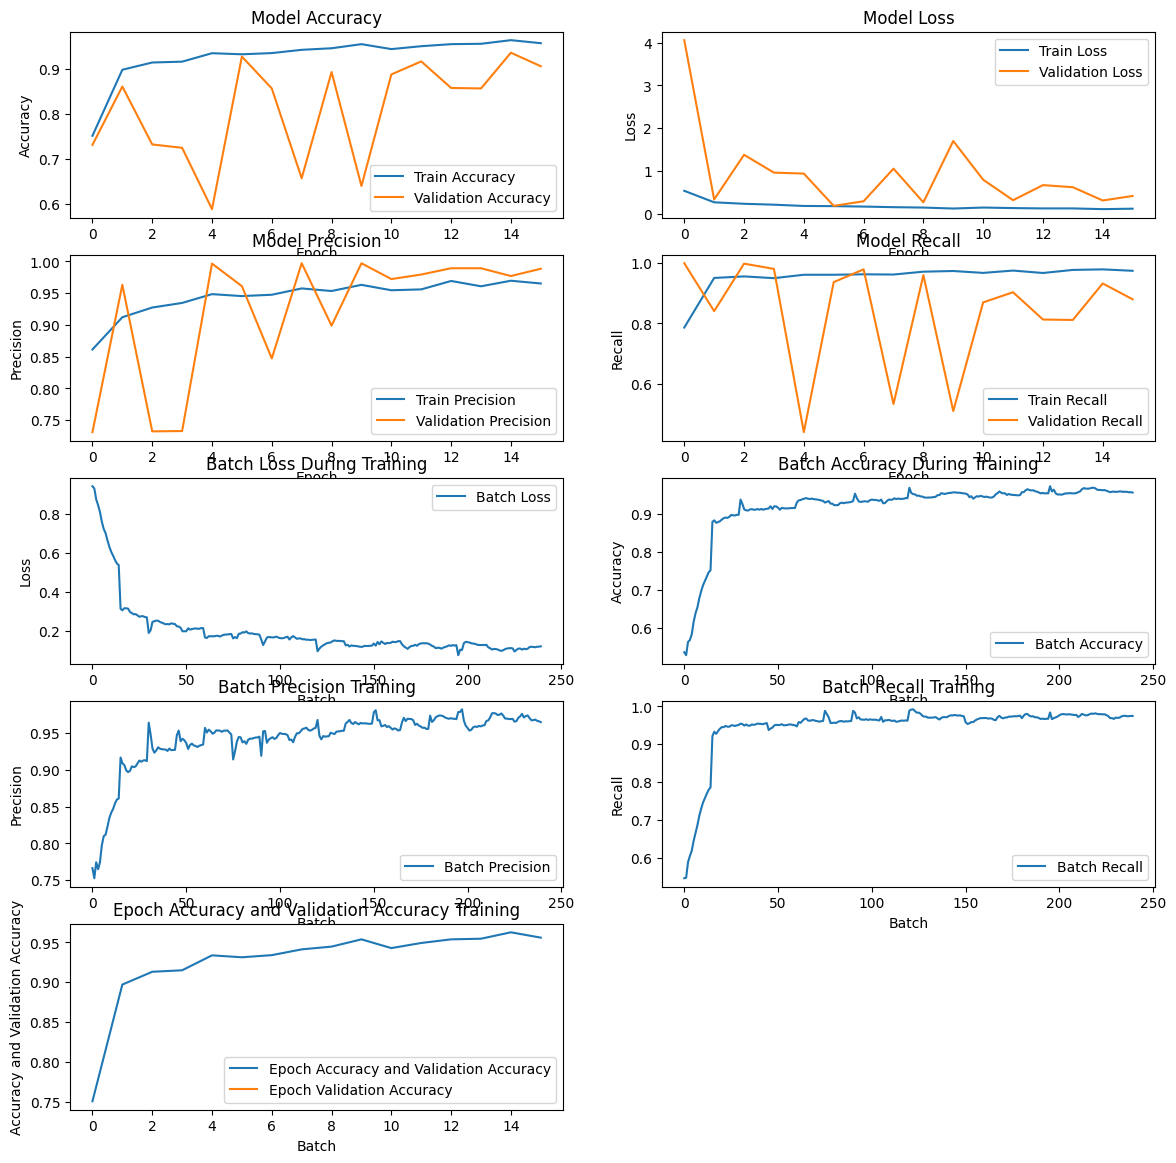

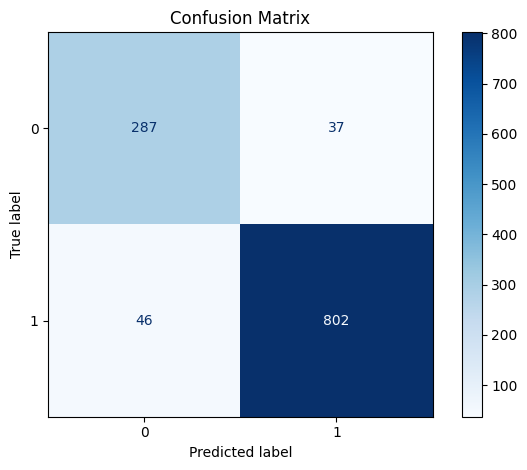

In [ ]:
#lr 0.015 base model, base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,256)

Epoch 1/100
 6/15 [===========>..................] - ETA: 4s - loss: 0.7410 - binary_accuracy: 0.7397 - precision: 0.8669 - recall: 0.7639

15/15 [==============================] - 17s 638ms/step - loss: 0.5403 - binary_accuracy: 0.7845 - precision: 0.8807 - recall: 0.8149 - val_loss: 3.6585 - val_binary_accuracy: 0.7311 - val_precision: 0.7311 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 9s 581ms/step - loss: 0.2625 - binary_accuracy: 0.8975 - precision: 0.9256 - recall: 0.9350 - val_loss: 1.2513 - val_binary_accuracy: 0.7311 - val_precision: 0.7311 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 9s 580ms/step - loss: 0.2125 - binary_accuracy: 0.9207 - precision: 0.9402 - recall: 0.9522 - val_loss: 3.7308 - val_binary_accuracy: 0.7311 - val_precision: 0.7311 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 9s 586ms/step - loss: 0.1848 - binary_accuracy: 0.9327 - precision: 0.9481 - recall: 0.9606 - val_loss: 0.5350 - val_binary_accuracy: 0.7364 - val_precision: 0.7765 - val_recall: 0.8978
Epoch 5/100
15/15 [==============================] - 9s

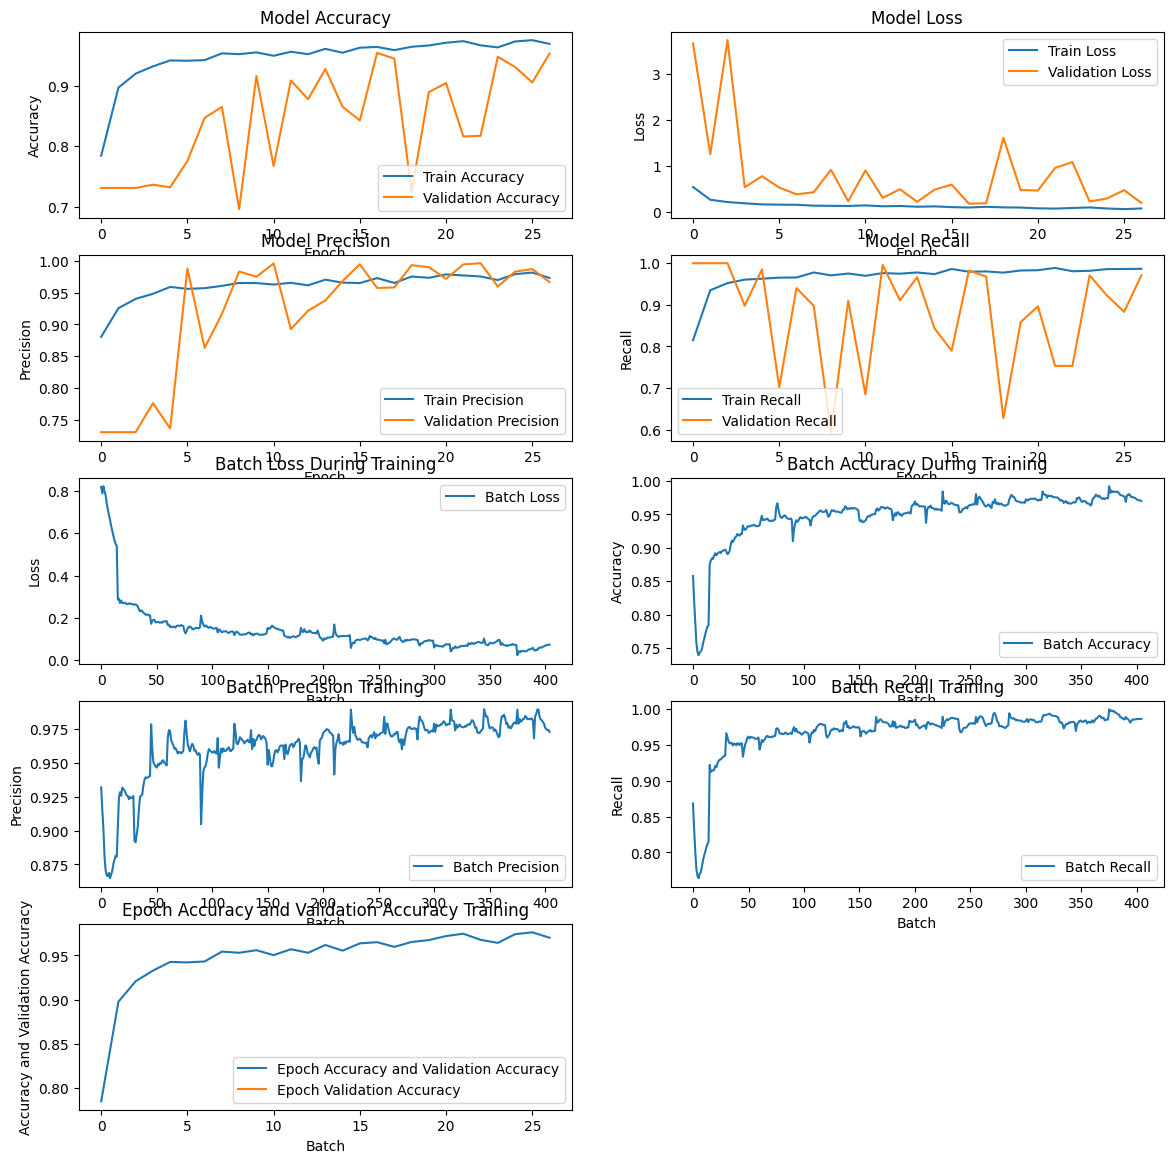

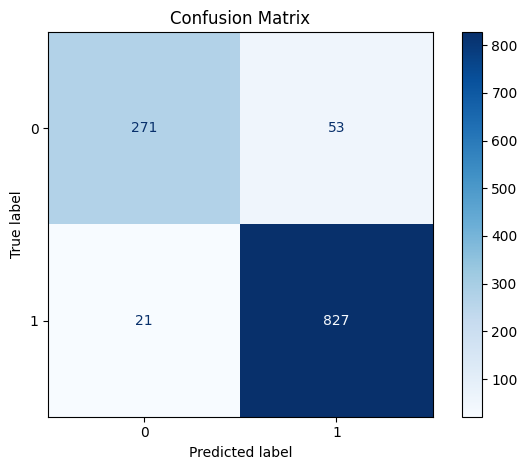

In [ ]:
#lr 0.015 model without last dropout, base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,256)

Epoch 1/100
 6/15 [===========>..................] - ETA: 4s - loss: 0.1097 - binary_accuracy: 0.9596 - precision: 0.9684 - recall: 0.9770

15/15 [==============================] - 10s 638ms/step - loss: 0.1012 - binary_accuracy: 0.9642 - precision: 0.9718 - recall: 0.9796 - val_loss: 0.5205 - val_binary_accuracy: 0.8773 - val_precision: 0.9931 - val_recall: 0.8380
Epoch 2/100
15/15 [==============================] - 8s 551ms/step - loss: 0.0992 - binary_accuracy: 0.9634 - precision: 0.9690 - recall: 0.9814 - val_loss: 2.9616 - val_binary_accuracy: 0.5987 - val_precision: 0.9905 - val_recall: 0.4555
Epoch 3/100
15/15 [==============================] - 9s 576ms/step - loss: 0.0807 - binary_accuracy: 0.9709 - precision: 0.9789 - recall: 0.9814 - val_loss: 3.0369 - val_binary_accuracy: 0.7257 - val_precision: 0.9931 - val_recall: 0.6292
Epoch 4/100
15/15 [==============================] - 9s 601ms/step - loss: 0.0915 - binary_accuracy: 0.9664 - precision: 0.9715 - recall: 0.9828 - val_loss: 0.3113 - val_binary_accuracy: 0.9104 - val_precision: 0.9855 - val_recall: 0.8905
Epoch 5/100
15/15 [==============================] - 9s

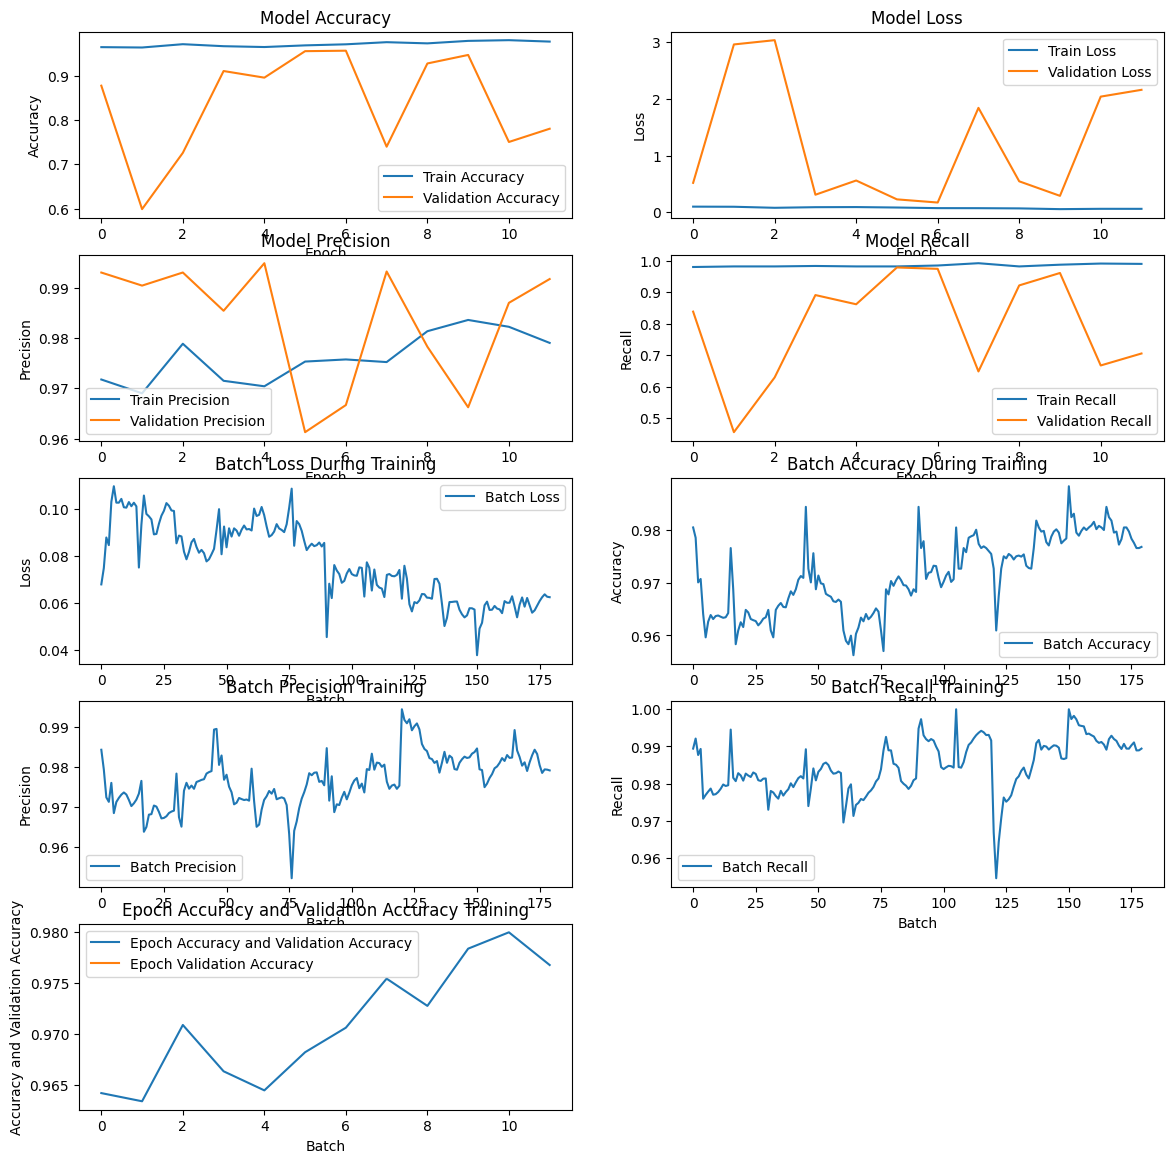

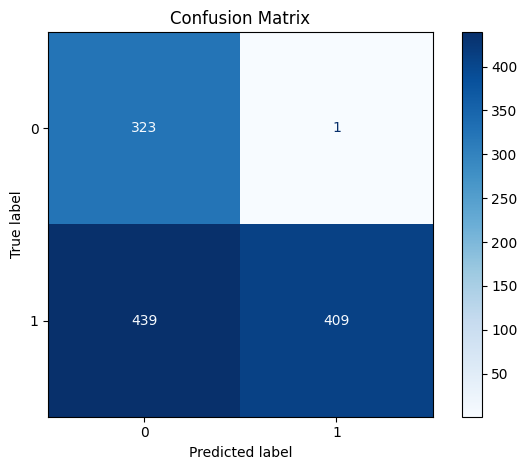

In [ ]:
#lr 0.015 model without last dropout, early stopping callback monitor on val_recall
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,256)

Epoch 1/100
 6/15 [===========>..................] - ETA: 4s - loss: 0.0572 - binary_accuracy: 0.9785 - precision: 0.9825 - recall: 0.9886

15/15 [==============================] - 9s 577ms/step - loss: 0.0550 - binary_accuracy: 0.9811 - precision: 0.9851 - recall: 0.9891 - val_loss: 0.8115 - val_binary_accuracy: 0.8869 - val_precision: 0.9882 - val_recall: 0.8555
Epoch 2/100
15/15 [==============================] - 8s 549ms/step - loss: 0.0440 - binary_accuracy: 0.9843 - precision: 0.9880 - recall: 0.9905 - val_loss: 0.5814 - val_binary_accuracy: 0.9264 - val_precision: 0.9858 - val_recall: 0.9124
Epoch 3/100
15/15 [==============================] - 8s 554ms/step - loss: 0.0539 - binary_accuracy: 0.9795 - precision: 0.9861 - recall: 0.9858 - val_loss: 0.7912 - val_binary_accuracy: 0.9007 - val_precision: 0.9917 - val_recall: 0.8715
Epoch 4/100
15/15 [==============================] - 9s 576ms/step - loss: 0.0547 - binary_accuracy: 0.9800 - precision: 0.9851 - recall: 0.9876 - val_loss: 0.2595 - val_binary_accuracy: 0.9434 - val_precision: 0.9817 - val_recall: 0.9401
Epoch 5/100
15/15 [==============================] - 9s 

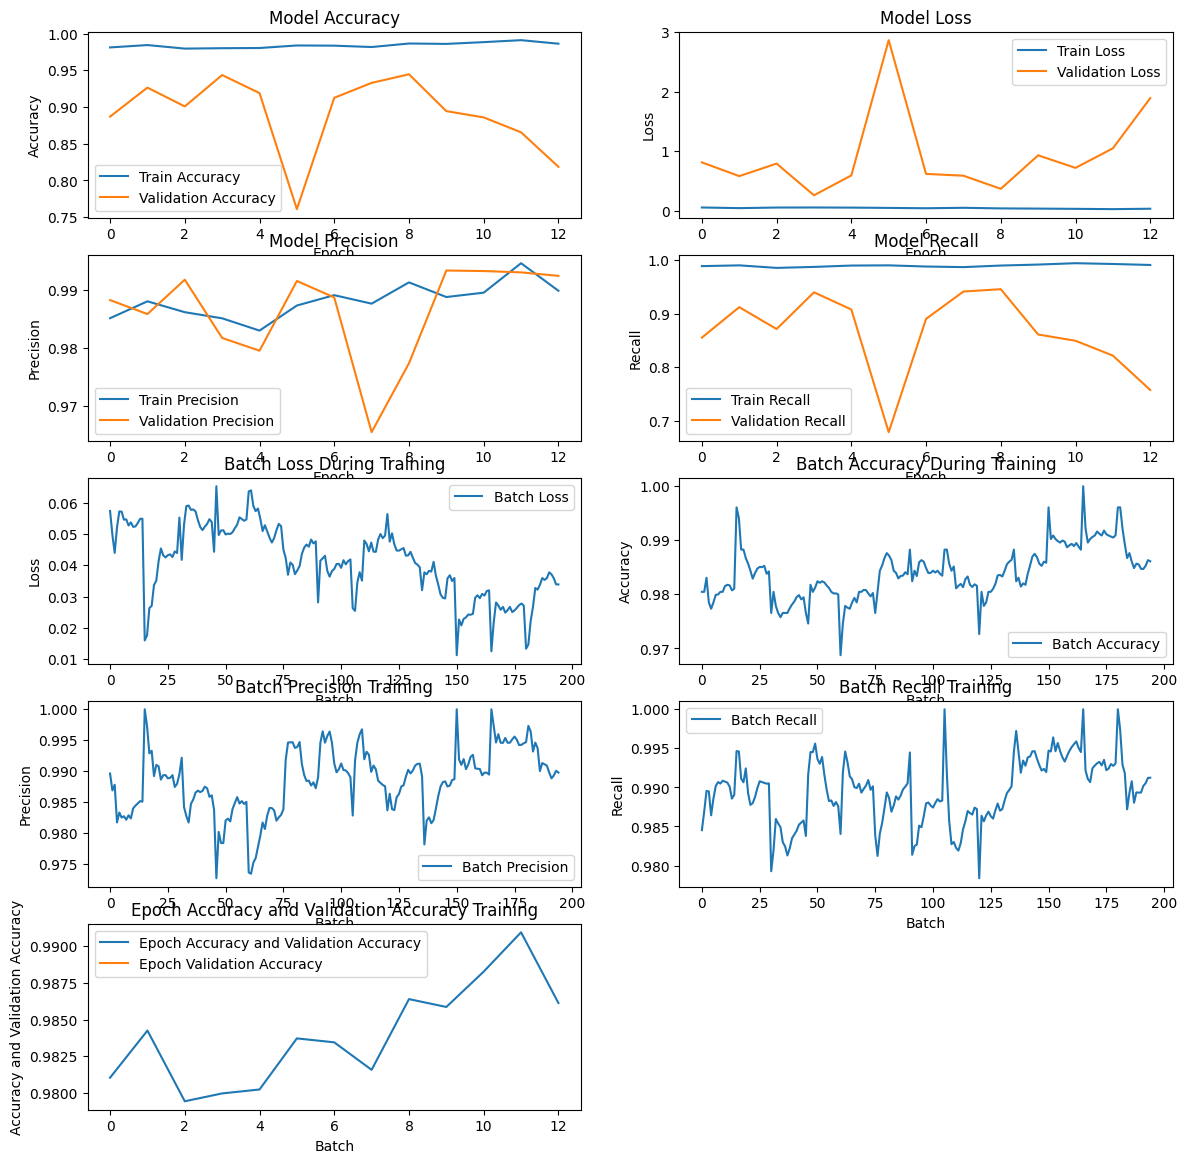

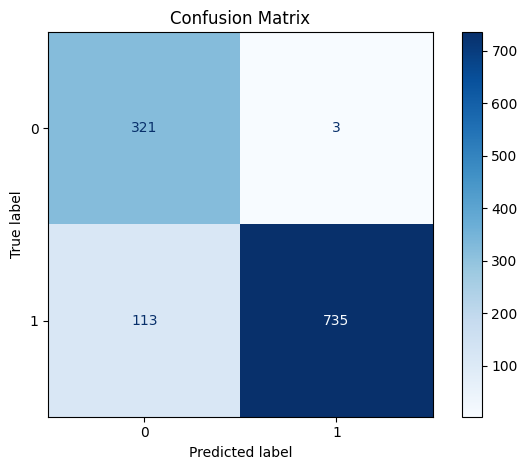

In [ ]:
#lr 0.015 model without last dropout, early stopping callback monitor on recall
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,256)

Epoch 1/100
 6/30 [=====>........................] - ETA: 6s - loss: 0.0439 - binary_accuracy: 0.9857 - precision: 0.9877 - recall: 0.9930

30/30 [==============================] - 16s 394ms/step - loss: 0.0856 - binary_accuracy: 0.9704 - precision: 0.9778 - recall: 0.9818 - val_loss: 2.0817 - val_binary_accuracy: 0.8570 - val_precision: 0.9876 - val_recall: 0.8146
Epoch 2/100
30/30 [==============================] - 9s 285ms/step - loss: 0.0964 - binary_accuracy: 0.9634 - precision: 0.9762 - recall: 0.9737 - val_loss: 0.9251 - val_binary_accuracy: 0.9018 - val_precision: 0.9759 - val_recall: 0.8876
Epoch 3/100
30/30 [==============================] - 9s 292ms/step - loss: 0.1046 - binary_accuracy: 0.9632 - precision: 0.9690 - recall: 0.9810 - val_loss: 2.3961 - val_binary_accuracy: 0.8538 - val_precision: 0.9928 - val_recall: 0.8058
Epoch 4/100
30/30 [==============================] - 9s 292ms/step - loss: 0.0964 - binary_accuracy: 0.9669 - precision: 0.9767 - recall: 0.9781 - val_loss: 1.2429 - val_binary_accuracy: 0.8602 - val_precision: 0.9877 - val_recall: 0.8190
Epoch 5/100
30/30 [==============================] - 8s

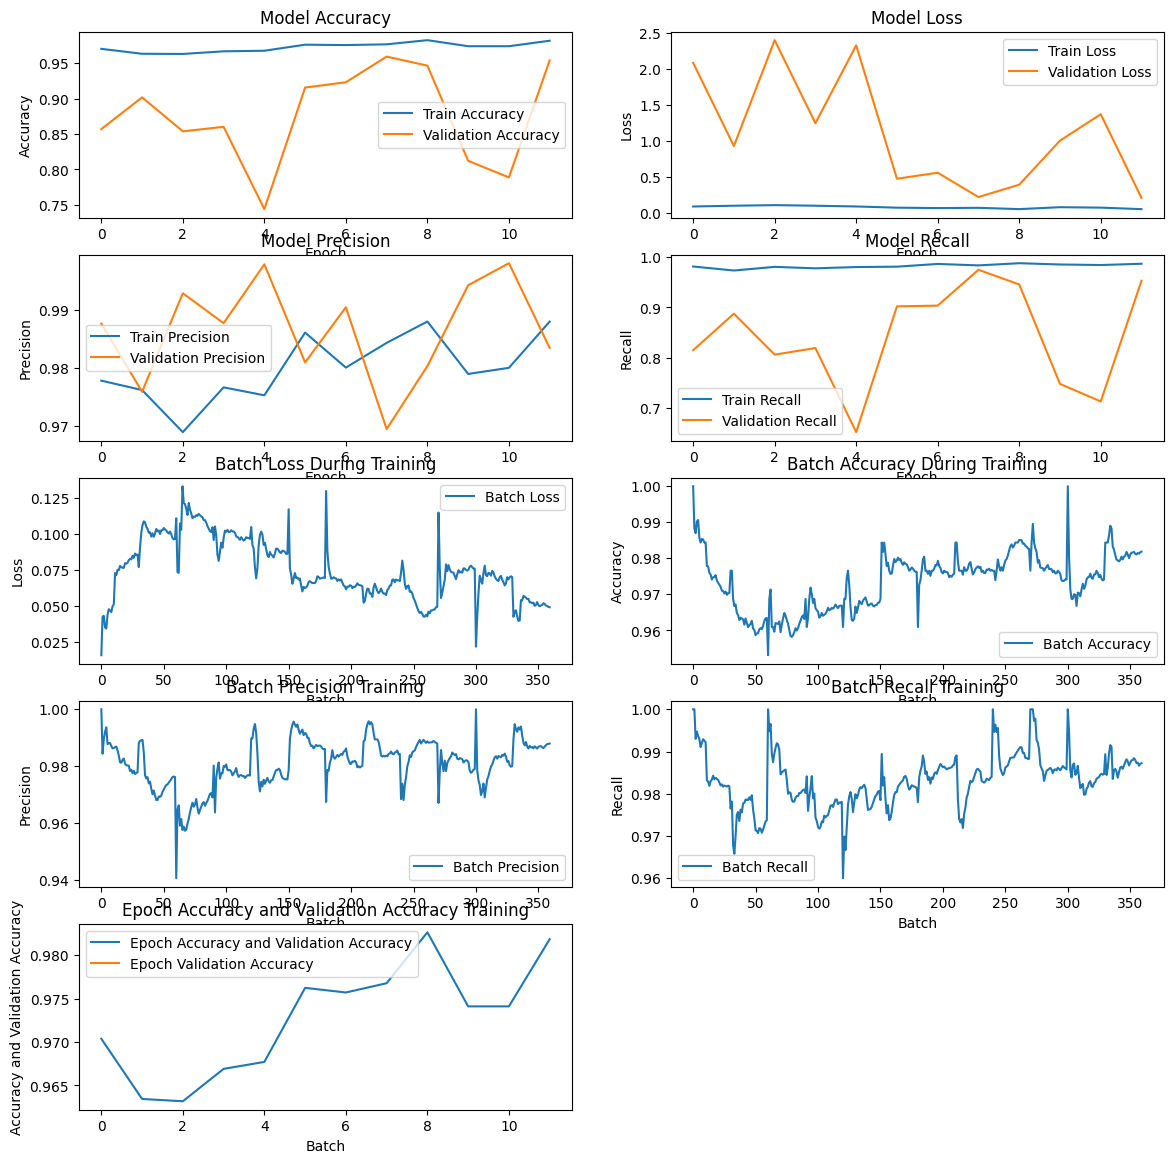

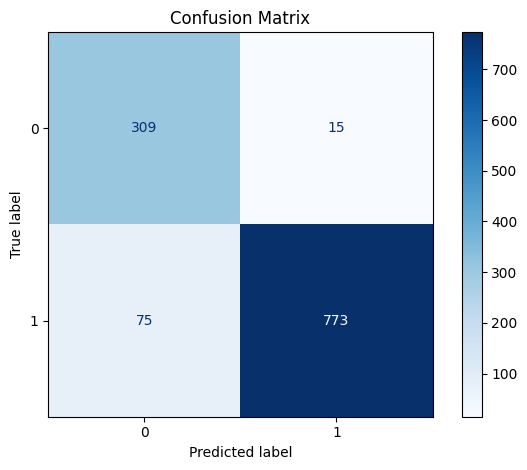

In [ ]:
#lr 0.015 model without last dropout, early stopping callback monitor on recall
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,128)

Epoch 1/100
 6/59 [==>...........................] - ETA: 7s - loss: 0.7530 - binary_accuracy: 0.6198 - precision: 0.8198 - recall: 0.6319

59/59 [==============================] - 27s 208ms/step - loss: 0.3686 - binary_accuracy: 0.8460 - precision: 0.8954 - recall: 0.8938 - val_loss: 0.3482 - val_binary_accuracy: 0.8559 - val_precision: 0.9365 - val_recall: 0.8613
Epoch 2/100
59/59 [==============================] - 8s 142ms/step - loss: 0.2405 - binary_accuracy: 0.9074 - precision: 0.9293 - recall: 0.9453 - val_loss: 0.7133 - val_binary_accuracy: 0.7588 - val_precision: 0.7599 - val_recall: 0.9796
Epoch 3/100
59/59 [==============================] - 8s 140ms/step - loss: 0.2112 - binary_accuracy: 0.9218 - precision: 0.9384 - recall: 0.9558 - val_loss: 0.4868 - val_binary_accuracy: 0.8463 - val_precision: 0.9856 - val_recall: 0.8015
Epoch 4/100
59/59 [==============================] - 9s 147ms/step - loss: 0.1961 - binary_accuracy: 0.9239 - precision: 0.9420 - recall: 0.9547 - val_loss: 1.2042 - val_binary_accuracy: 0.6585 - val_precision: 0.9973 - val_recall: 0.5343
Epoch 5/100
59/59 [==============================] - 8s

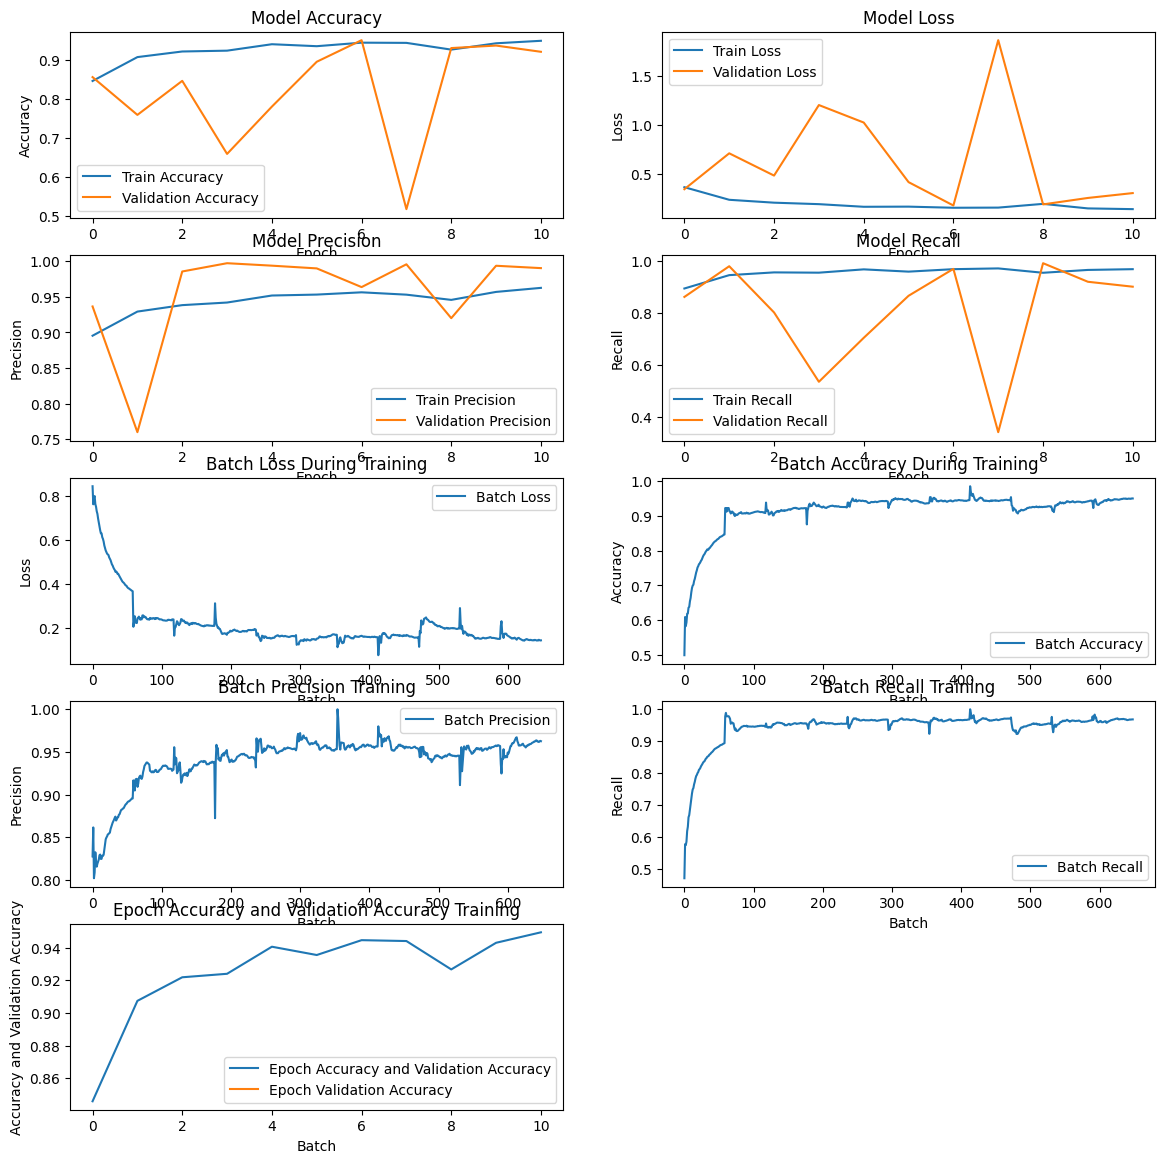

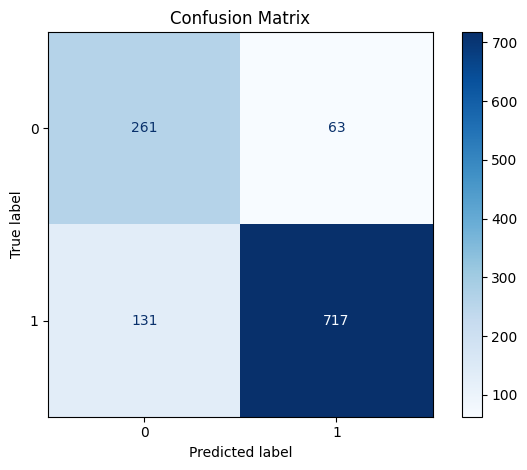

In [ ]:
#lr 0.015 model without last dropout, early stopping callback monitor on recall
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,64)

Epoch 1/100
 6/30 [=====>........................] - ETA: 6s - loss: 0.2302 - binary_accuracy: 0.9102 - precision: 0.9278 - recall: 0.9495

30/30 [==============================] - 14s 345ms/step - loss: 0.2446 - binary_accuracy: 0.9037 - precision: 0.9241 - recall: 0.9460 - val_loss: 0.3017 - val_binary_accuracy: 0.9157 - val_precision: 0.9734 - val_recall: 0.9095
Epoch 2/100
30/30 [==============================] - 9s 287ms/step - loss: 0.1962 - binary_accuracy: 0.9271 - precision: 0.9429 - recall: 0.9584 - val_loss: 7.2919 - val_binary_accuracy: 0.2743 - val_precision: 1.0000 - val_recall: 0.0073
Epoch 3/100
30/30 [==============================] - 9s 296ms/step - loss: 0.1921 - binary_accuracy: 0.9319 - precision: 0.9474 - recall: 0.9602 - val_loss: 13.1171 - val_binary_accuracy: 0.2732 - val_precision: 1.0000 - val_recall: 0.0058
Epoch 4/100
30/30 [==============================] - 9s 294ms/step - loss: 0.1686 - binary_accuracy: 0.9402 - precision: 0.9486 - recall: 0.9708 - val_loss: 0.7913 - val_binary_accuracy: 0.8026 - val_precision: 0.9941 - val_recall: 0.7343
Epoch 5/100
30/30 [==============================] - 9

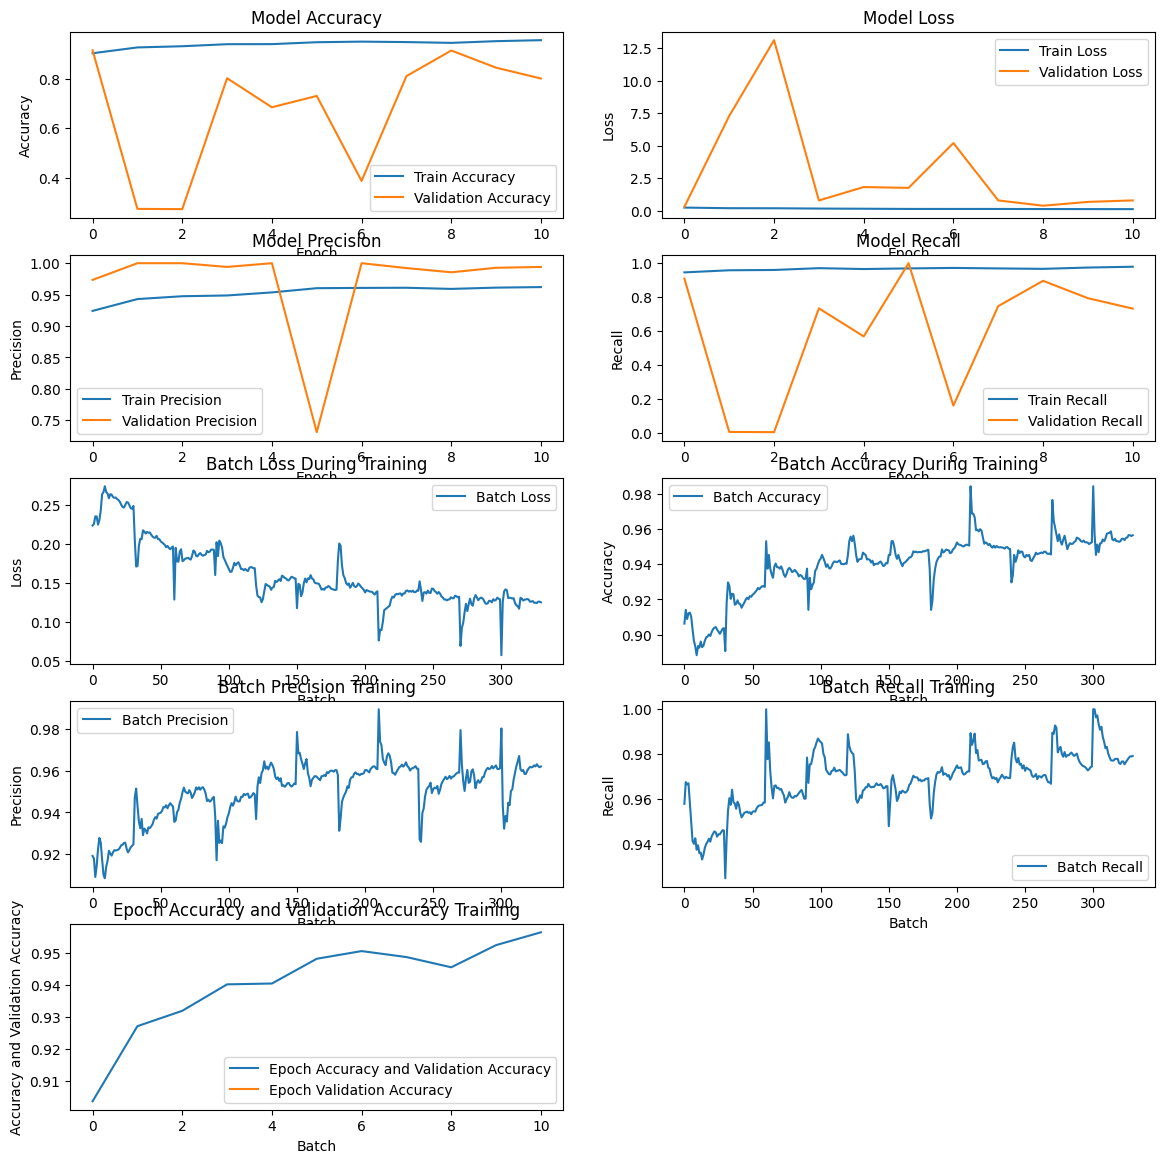

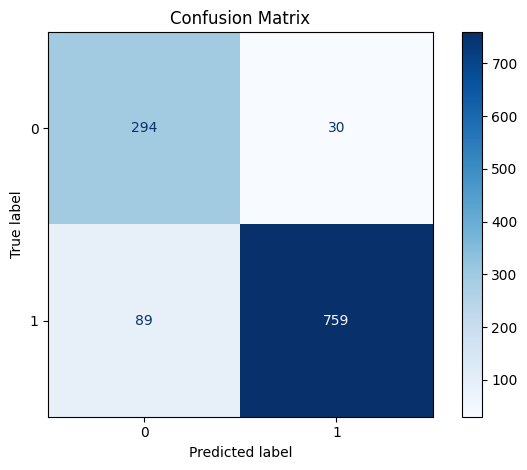

In [ ]:
#lr 0.015 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,128)

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.1901 - binary_accuracy: 0.9307 - precision: 0.9389 - recall: 0.9685

8/8 [==============================] - 34s 3s/step - loss: 0.1868 - binary_accuracy: 0.9309 - precision: 0.9397 - recall: 0.9675 - val_loss: 0.8893 - val_binary_accuracy: 0.7898 - val_precision: 0.7811 - val_recall: 0.9898
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.1757 - binary_accuracy: 0.9346 - precision: 0.9502 - recall: 0.9609 - val_loss: 5.0895 - val_binary_accuracy: 0.2775 - val_precision: 1.0000 - val_recall: 0.0117
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.1598 - binary_accuracy: 0.9413 - precision: 0.9539 - recall: 0.9664 - val_loss: 9.1144 - val_binary_accuracy: 0.2764 - val_precision: 1.0000 - val_recall: 0.0102
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.1675 - binary_accuracy: 0.9362 - precision: 0.9510 - recall: 0.9624 - val_loss: 8.5493 - val_binary_accuracy: 0.2764 - val_precision: 1.0000 - val_recall: 0.0102
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.151

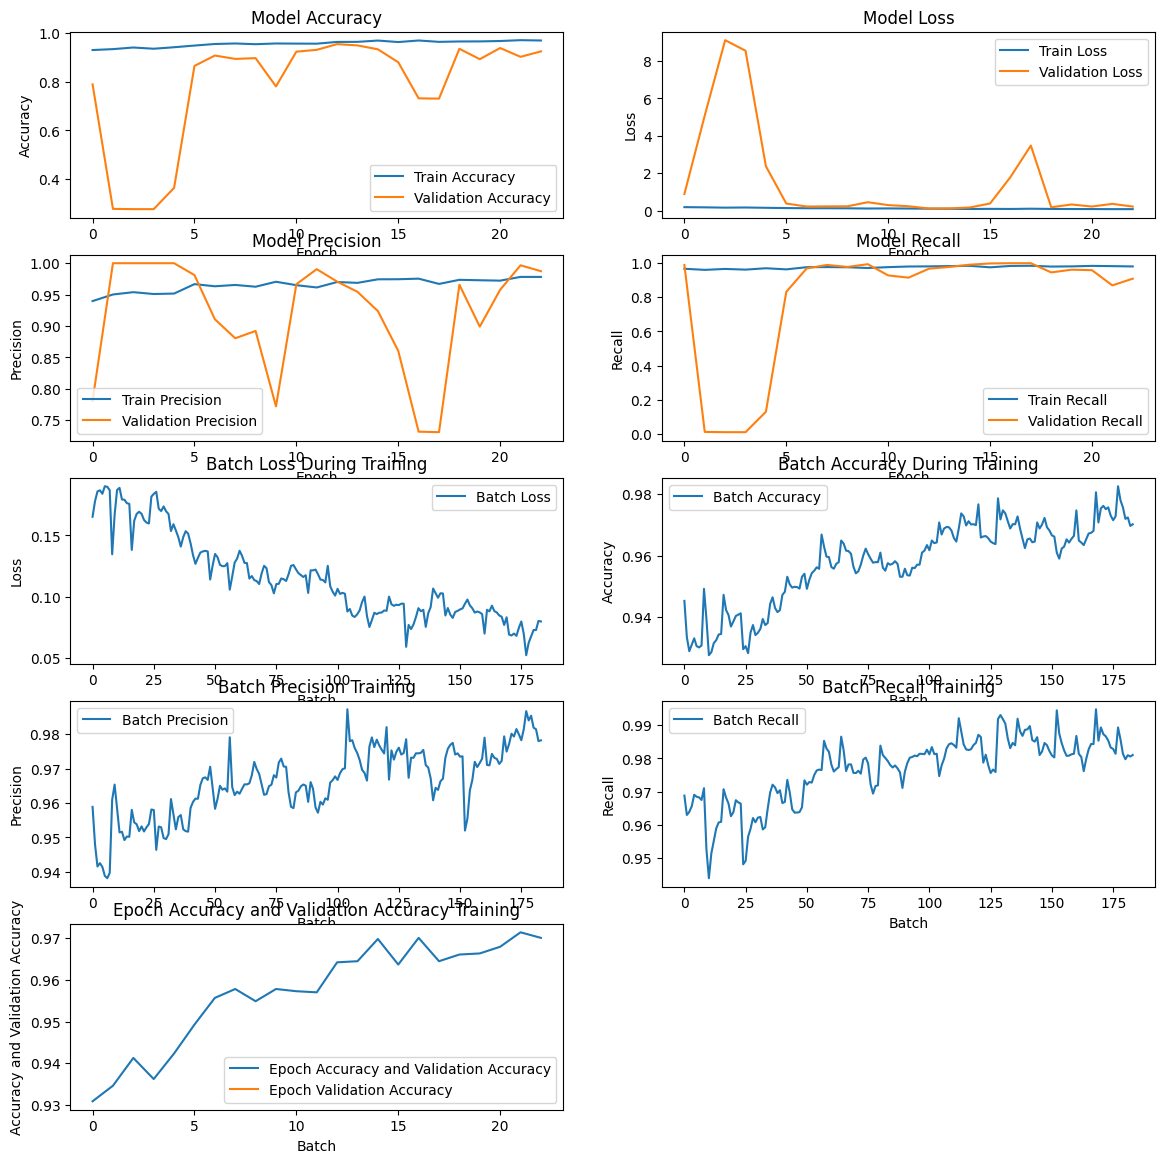

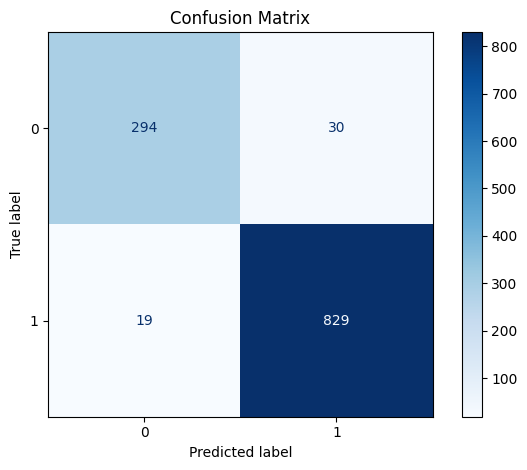

In [ ]:
#lr 0.015 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512)

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9639 - precision: 0.9688 - recall: 0.9815

8/8 [==============================] - 9s 1s/step - loss: 0.0982 - binary_accuracy: 0.9637 - precision: 0.9721 - recall: 0.9785 - val_loss: 0.1506 - val_binary_accuracy: 0.9392 - val_precision: 0.9290 - val_recall: 0.9927
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.0834 - binary_accuracy: 0.9698 - precision: 0.9723 - recall: 0.9869 - val_loss: 0.1616 - val_binary_accuracy: 0.9274 - val_precision: 0.9130 - val_recall: 0.9956
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.1036 - binary_accuracy: 0.9626 - precision: 0.9707 - recall: 0.9785 - val_loss: 0.1661 - val_binary_accuracy: 0.9477 - val_precision: 0.9848 - val_recall: 0.9431
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.1017 - binary_accuracy: 0.9618 - precision: 0.9706 - recall: 0.9774 - val_loss: 0.3222 - val_binary_accuracy: 0.8997 - val_precision: 0.8813 - val_recall: 0.9971
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.0967

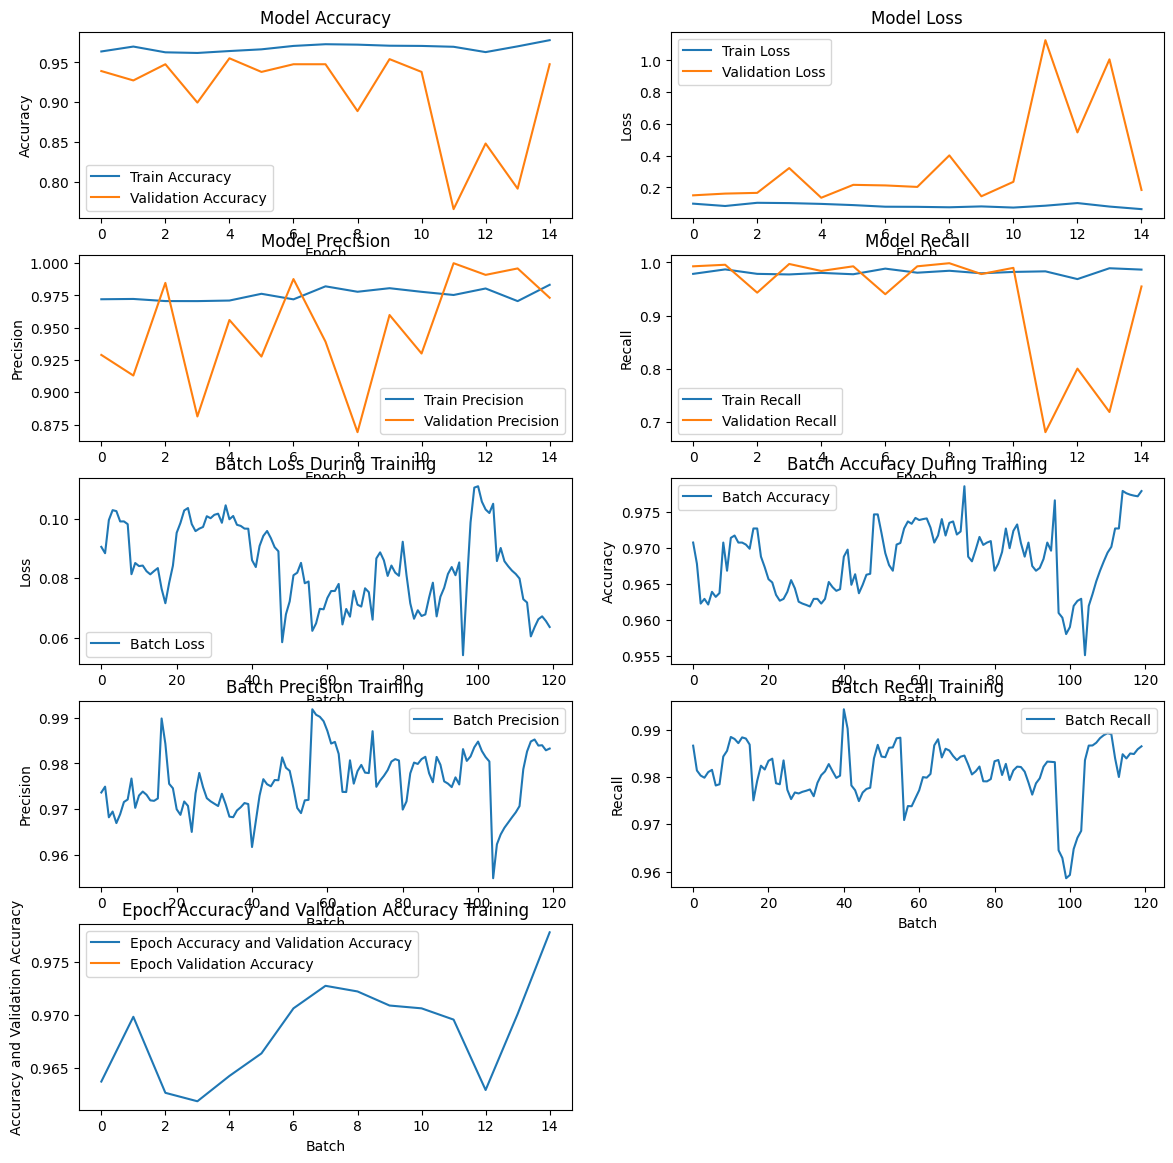

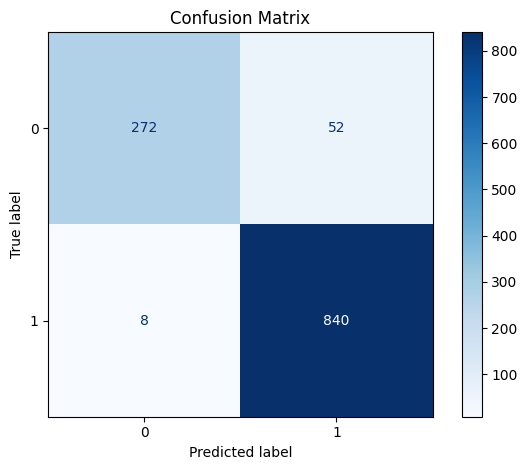

In [ ]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512)

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.0848 - binary_accuracy: 0.9668 - precision: 0.9753 - recall: 0.9796

8/8 [==============================] - 9s 1s/step - loss: 0.0874 - binary_accuracy: 0.9656 - precision: 0.9735 - recall: 0.9796 - val_loss: 0.7639 - val_binary_accuracy: 0.8111 - val_precision: 0.7947 - val_recall: 1.0000
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.0829 - binary_accuracy: 0.9696 - precision: 0.9713 - recall: 0.9876 - val_loss: 2.0407 - val_binary_accuracy: 0.7321 - val_precision: 0.7318 - val_recall: 1.0000
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.0815 - binary_accuracy: 0.9666 - precision: 0.9715 - recall: 0.9832 - val_loss: 1.8585 - val_binary_accuracy: 0.7385 - val_precision: 0.7366 - val_recall: 1.0000
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.0855 - binary_accuracy: 0.9680 - precision: 0.9785 - recall: 0.9777 - val_loss: 0.1631 - val_binary_accuracy: 0.9520 - val_precision: 0.9482 - val_recall: 0.9883
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.0946

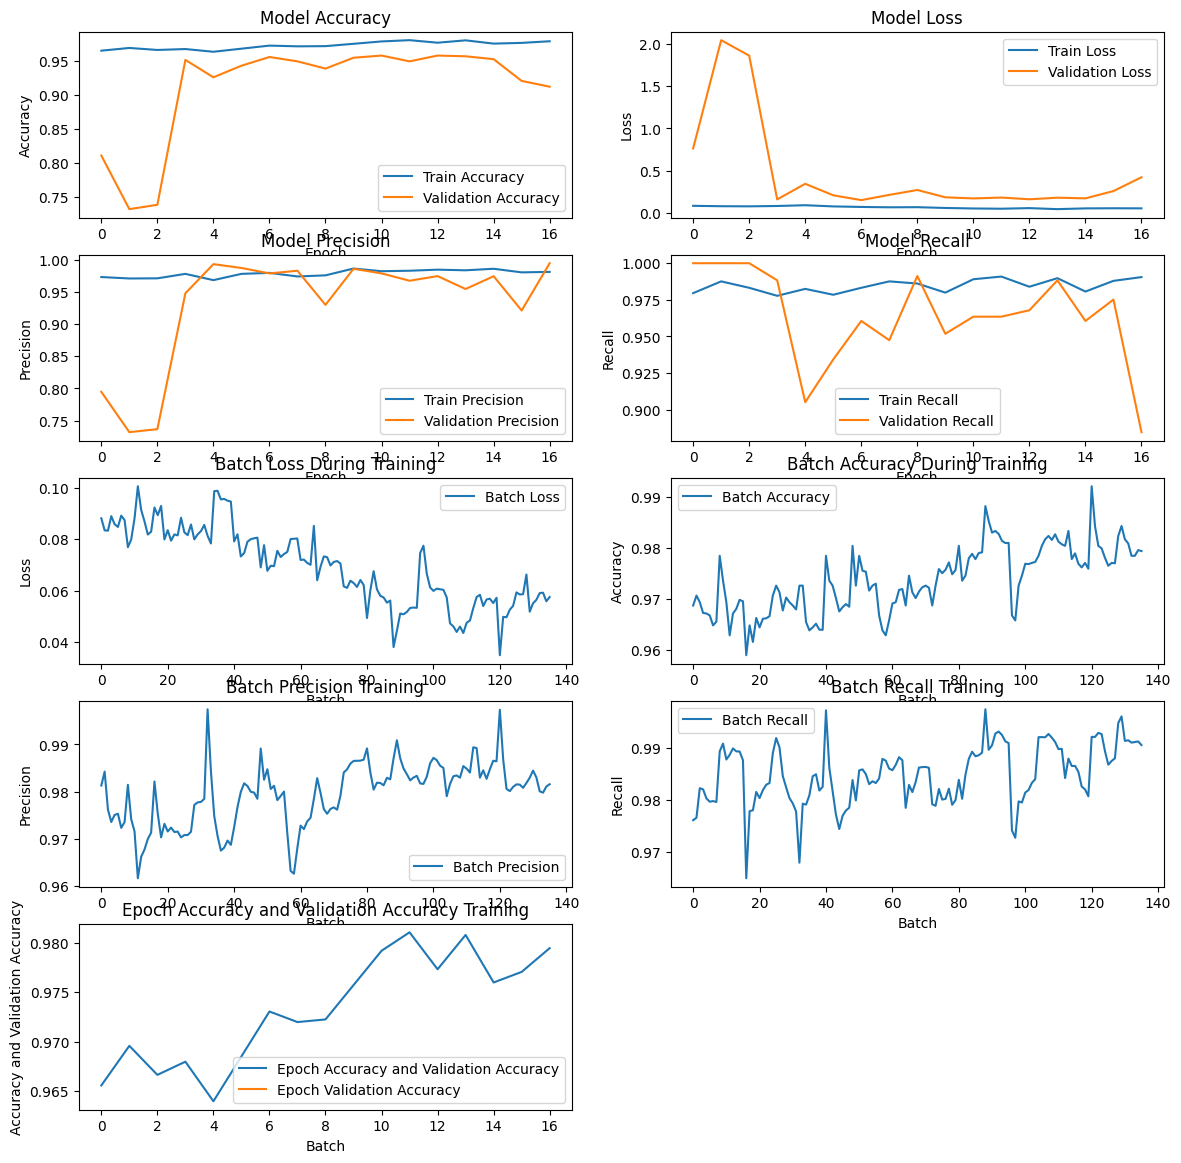

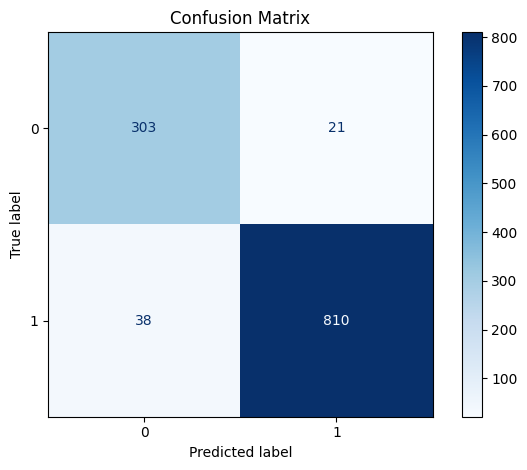

In [ ]:
#lr 0.005 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512)

Based on the previous we can make conclusion :
- She should not touch the Early stopping monitor parameter. We got a better recall with the default value.
- The model is better without the last Dropout layer. Having this last layer was useless because we just dropped the learning made by the model by stopped working after that.
- The 0.O1 value for LR is better than 0.015. It gives us better recall which is the metric we wanna focus on.

We can now test new things such as :
- Class weights to correct imbalance in the dataset
- Data augmentation
- New loss function : Focal Loss
- Adjust Learning Rate Schedule
- Increase Model Capacity


Class Weights :

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.0787 - binary_accuracy: 0.9720 - precision: 0.9835 - recall: 0.9783

8/8 [==============================] - 11s 1s/step - loss: 0.0853 - binary_accuracy: 0.9717 - precision: 0.9828 - recall: 0.9785 - val_loss: 0.5039 - val_binary_accuracy: 0.8719 - val_precision: 0.9982 - val_recall: 0.8263
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.0976 - binary_accuracy: 0.9624 - precision: 0.9920 - recall: 0.9562 - val_loss: 0.2372 - val_binary_accuracy: 0.9434 - val_precision: 0.9892 - val_recall: 0.9328
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.0942 - binary_accuracy: 0.9680 - precision: 0.9881 - recall: 0.9679 - val_loss: 0.3618 - val_binary_accuracy: 0.8965 - val_precision: 0.9933 - val_recall: 0.8642
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.0967 - binary_accuracy: 0.9616 - precision: 0.9883 - recall: 0.9588 - val_loss: 0.5343 - val_binary_accuracy: 0.8559 - val_precision: 0.9964 - val_recall: 0.8058
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.084

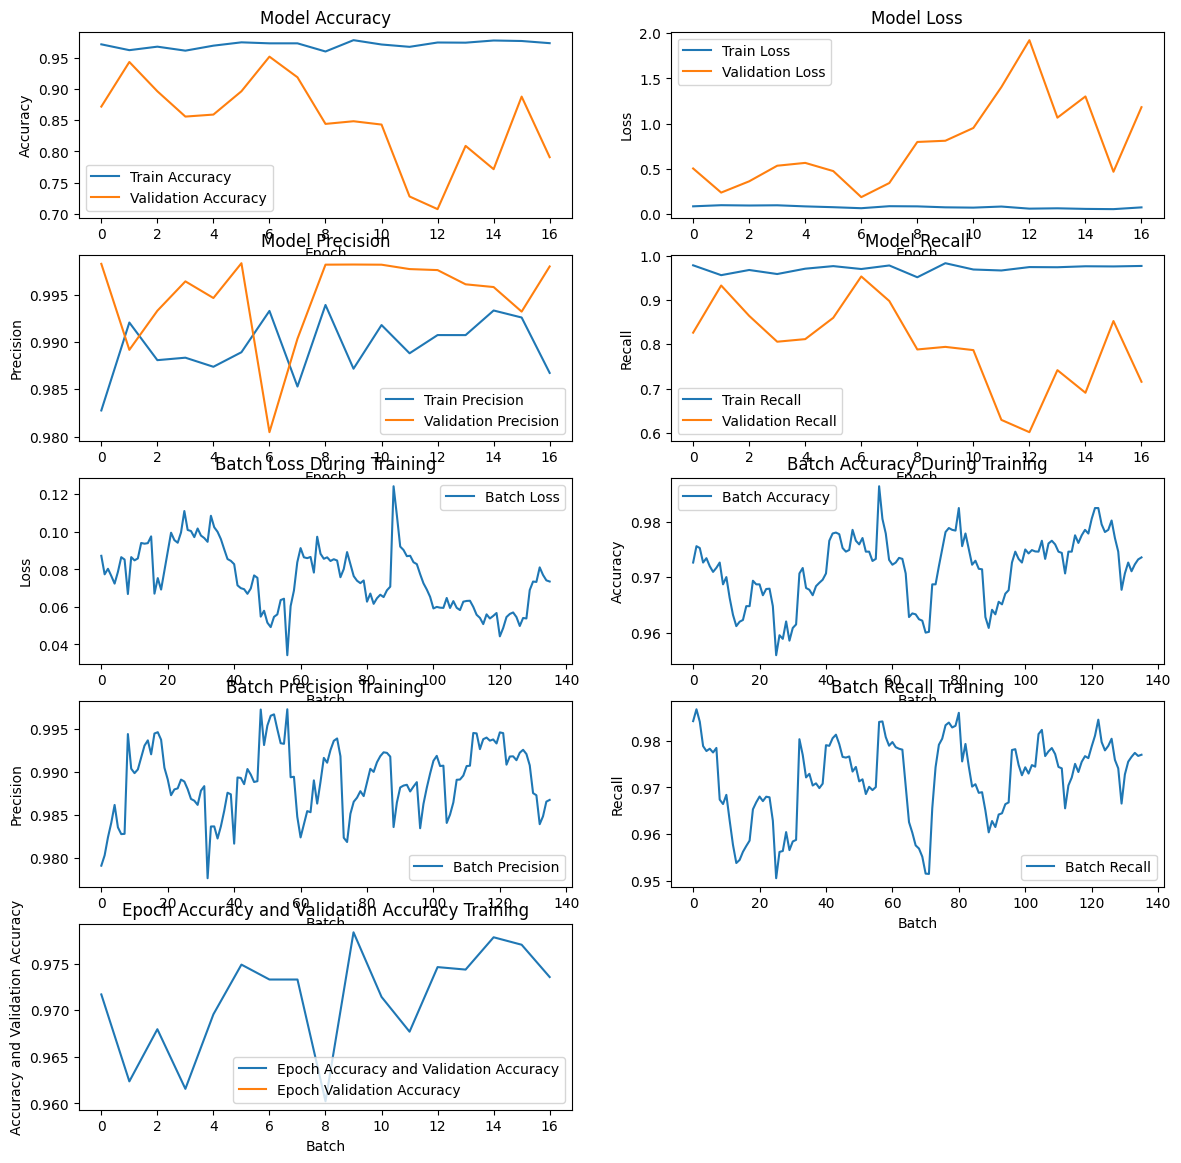

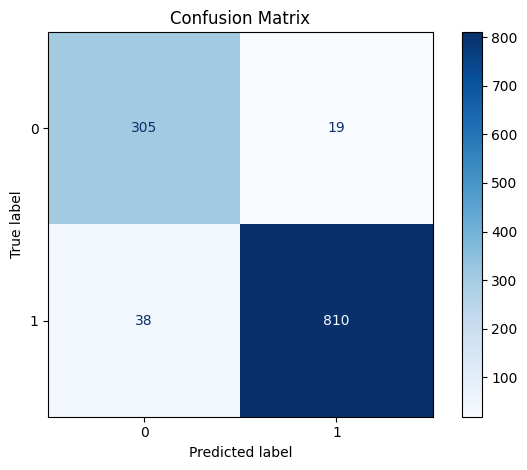

In [ ]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512,useClassWeights=True)

Data generation :

Epoch 1/100
10/10 [==============================] - 21s 2s/step - loss: 0.1978 - binary_accuracy: 0.9276 - precision: 0.9480 - recall: 0.9533 - val_loss: 2.3183 - val_binary_accuracy: 0.4642 - val_precision: 0.9955 - val_recall: 0.2606
Epoch 2/100
10/10 [==============================] - 20s 2s/step - loss: 0.2009 - binary_accuracy: 0.9234 - precision: 0.9467 - recall: 0.9486 - val_loss: 0.5078 - val_binary_accuracy: 0.8225 - val_precision: 0.9878 - val_recall: 0.7642
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 0.1911 - binary_accuracy: 0.9291 - precision: 0.9476 - recall: 0.9559 - val_loss: 0.4359 - val_binary_accuracy: 0.8635 - val_precision: 0.8568 - val_recall: 0.9741
Epoch 4/100
10/10 [==============================] - 19s 2s/step - loss: 0.1862 - binary_accuracy: 0.9323 - precision: 0.9504 - recall: 0.9574 - val_loss: 0.8373 - val_binary_accuracy: 0.7611 - val_precision: 0.7549 - val_recall: 0.9917
Epoch 5/100
10/10 [==============================] -

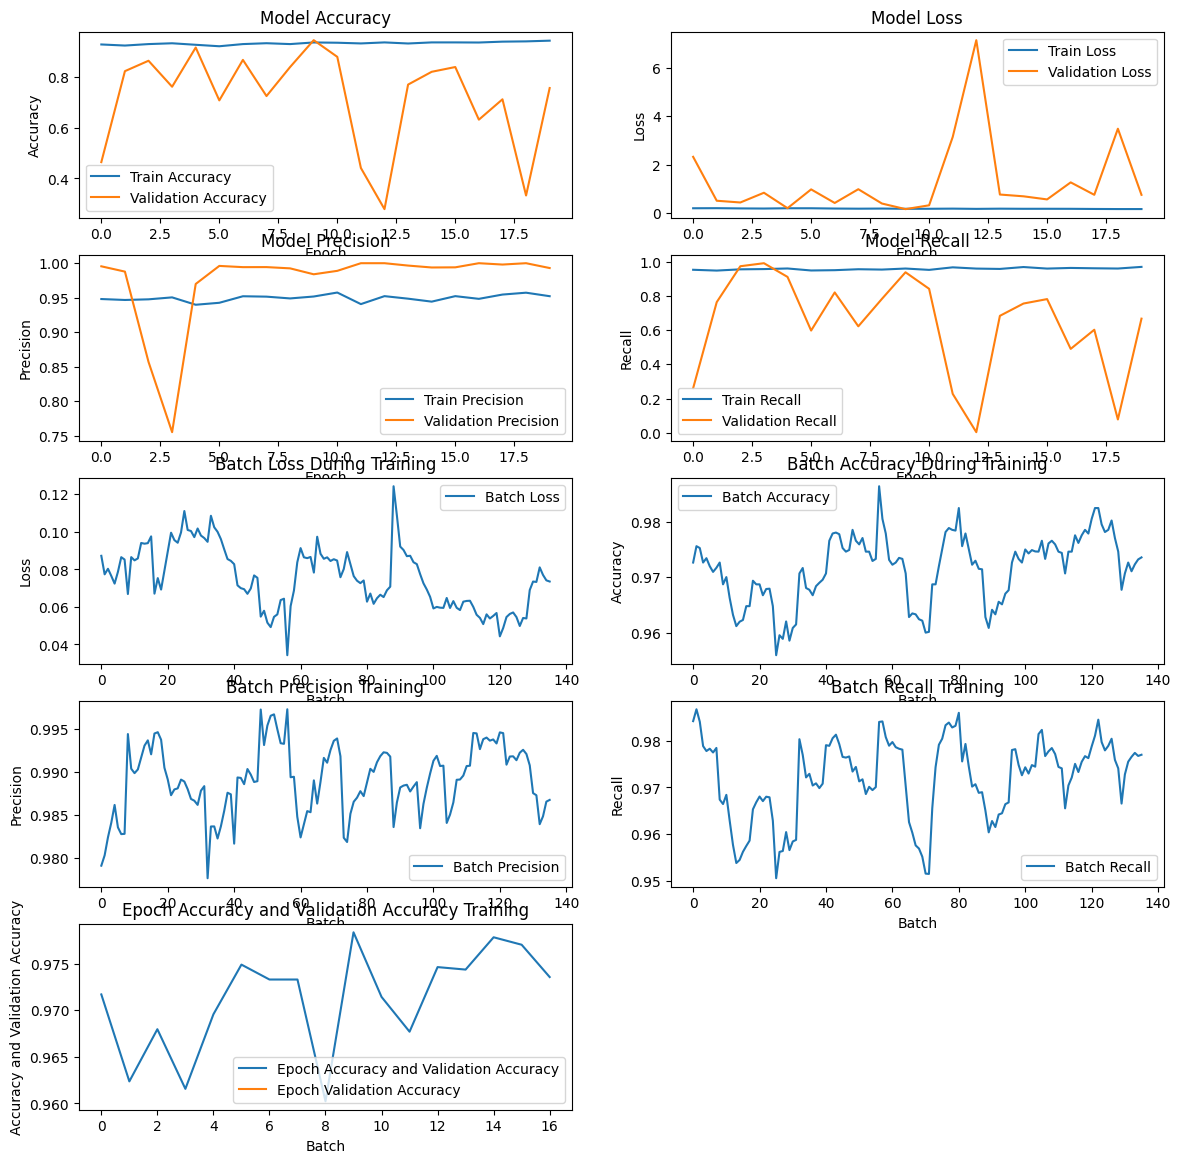

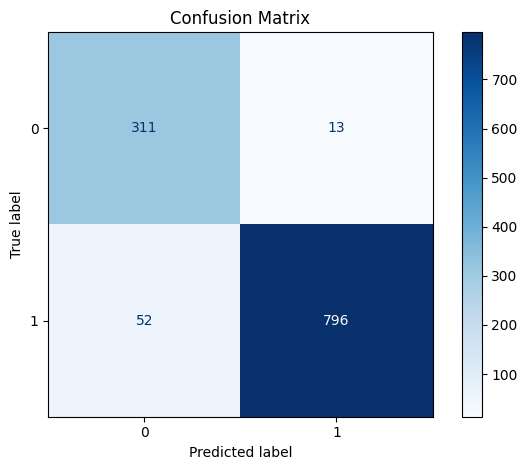

In [ ]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512,useDataGeneration=True)

Custom Loss Function: Focal Loss

In [27]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_true = K.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = - alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=focal_loss(), metrics=METRICS)

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.0371 - binary_accuracy: 0.9189 - precision: 0.9601 - recall: 0.9271

8/8 [==============================] - 16s 1s/step - loss: 0.0337 - binary_accuracy: 0.9205 - precision: 0.9624 - recall: 0.9273 - val_loss: 0.0462 - val_binary_accuracy: 0.8687 - val_precision: 0.8737 - val_recall: 0.9591
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.0214 - binary_accuracy: 0.9183 - precision: 0.9649 - recall: 0.9219 - val_loss: 0.3122 - val_binary_accuracy: 0.4856 - val_precision: 1.0000 - val_recall: 0.2964
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.0182 - binary_accuracy: 0.9410 - precision: 0.9673 - recall: 0.9515 - val_loss: 0.1241 - val_binary_accuracy: 0.9007 - val_precision: 0.9540 - val_recall: 0.9080
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.0155 - binary_accuracy: 0.9367 - precision: 0.9808 - recall: 0.9318 - val_loss: 0.0821 - val_binary_accuracy: 0.9210 - val_precision: 0.9371 - val_recall: 0.9562
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.014

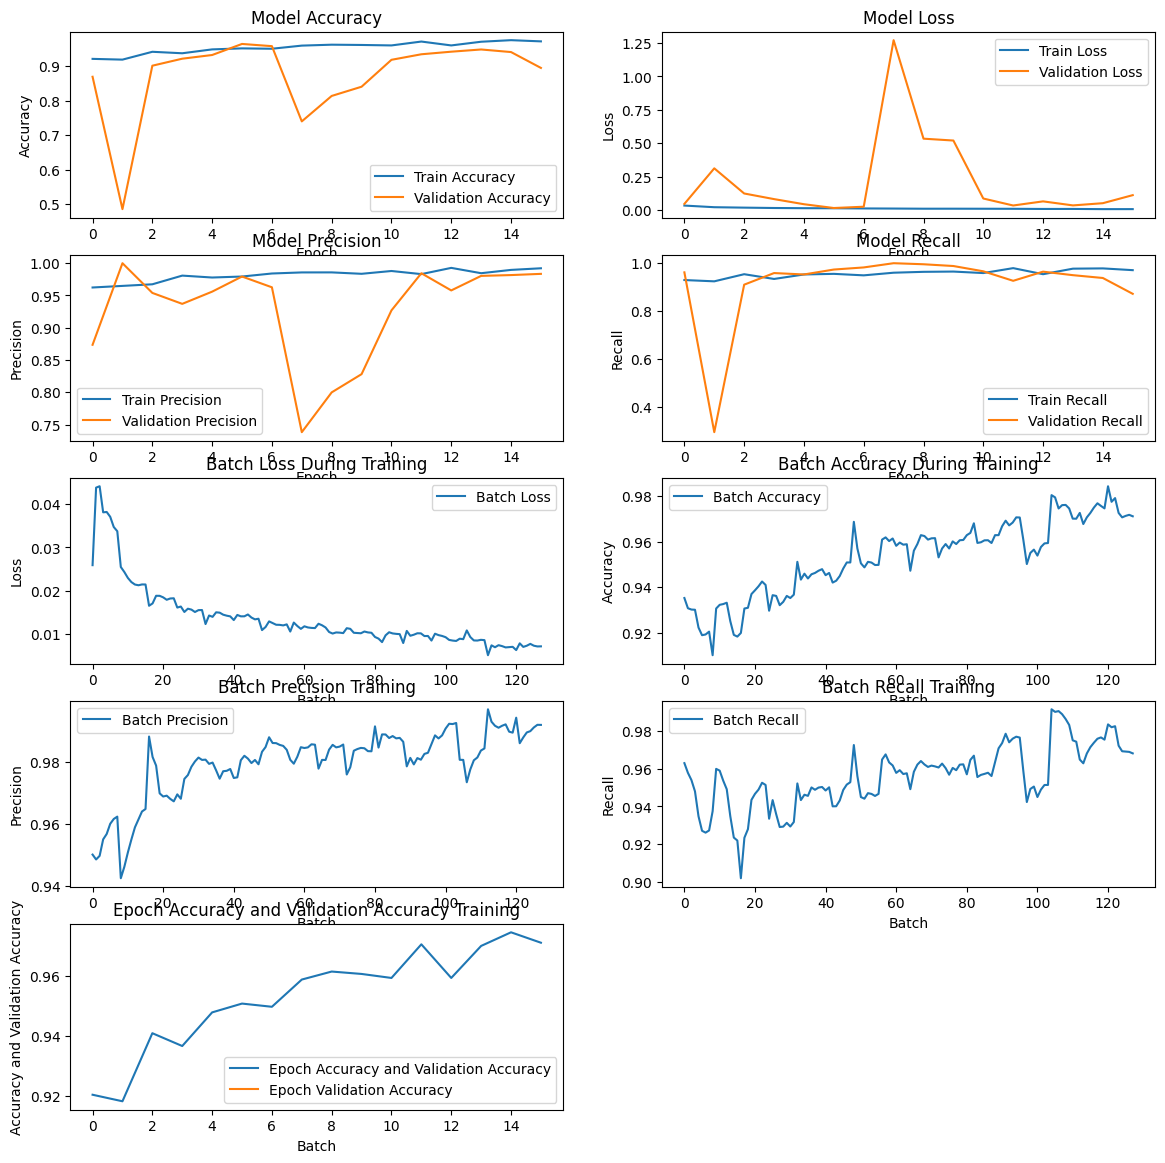

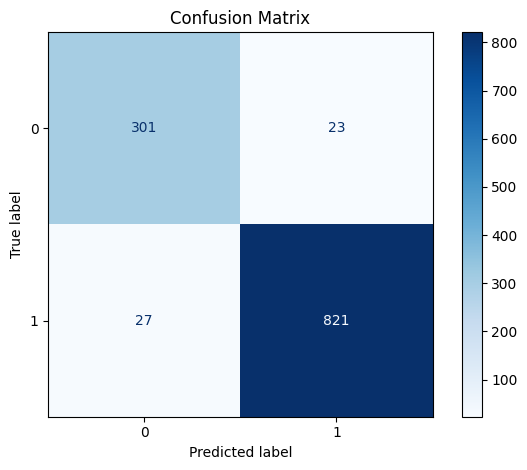

In [28]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512)

Adjust Learning Rate Schedule

In [30]:
initial_learning_rate = 0.010
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=50000, decay_rate=0.90, staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy', metrics=METRICS)

Epoch 1/100
6/8 [=====================>........] - ETA: 2s - loss: 0.1510 - binary_accuracy: 0.9578 - precision: 0.9683 - recall: 0.9743

8/8 [==============================] - 16s 1s/step - loss: 0.1486 - binary_accuracy: 0.9565 - precision: 0.9671 - recall: 0.9735 - val_loss: 1.3693 - val_binary_accuracy: 0.8346 - val_precision: 0.9926 - val_recall: 0.7796
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.1130 - binary_accuracy: 0.9594 - precision: 0.9743 - recall: 0.9701 - val_loss: 0.9743 - val_binary_accuracy: 0.9039 - val_precision: 0.9885 - val_recall: 0.8788
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.1029 - binary_accuracy: 0.9642 - precision: 0.9640 - recall: 0.9880 - val_loss: 0.7319 - val_binary_accuracy: 0.9242 - val_precision: 0.9782 - val_recall: 0.9168
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.0956 - binary_accuracy: 0.9666 - precision: 0.9798 - recall: 0.9745 - val_loss: 0.7059 - val_binary_accuracy: 0.9360 - val_precision: 0.9522 - val_recall: 0.9606
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.081

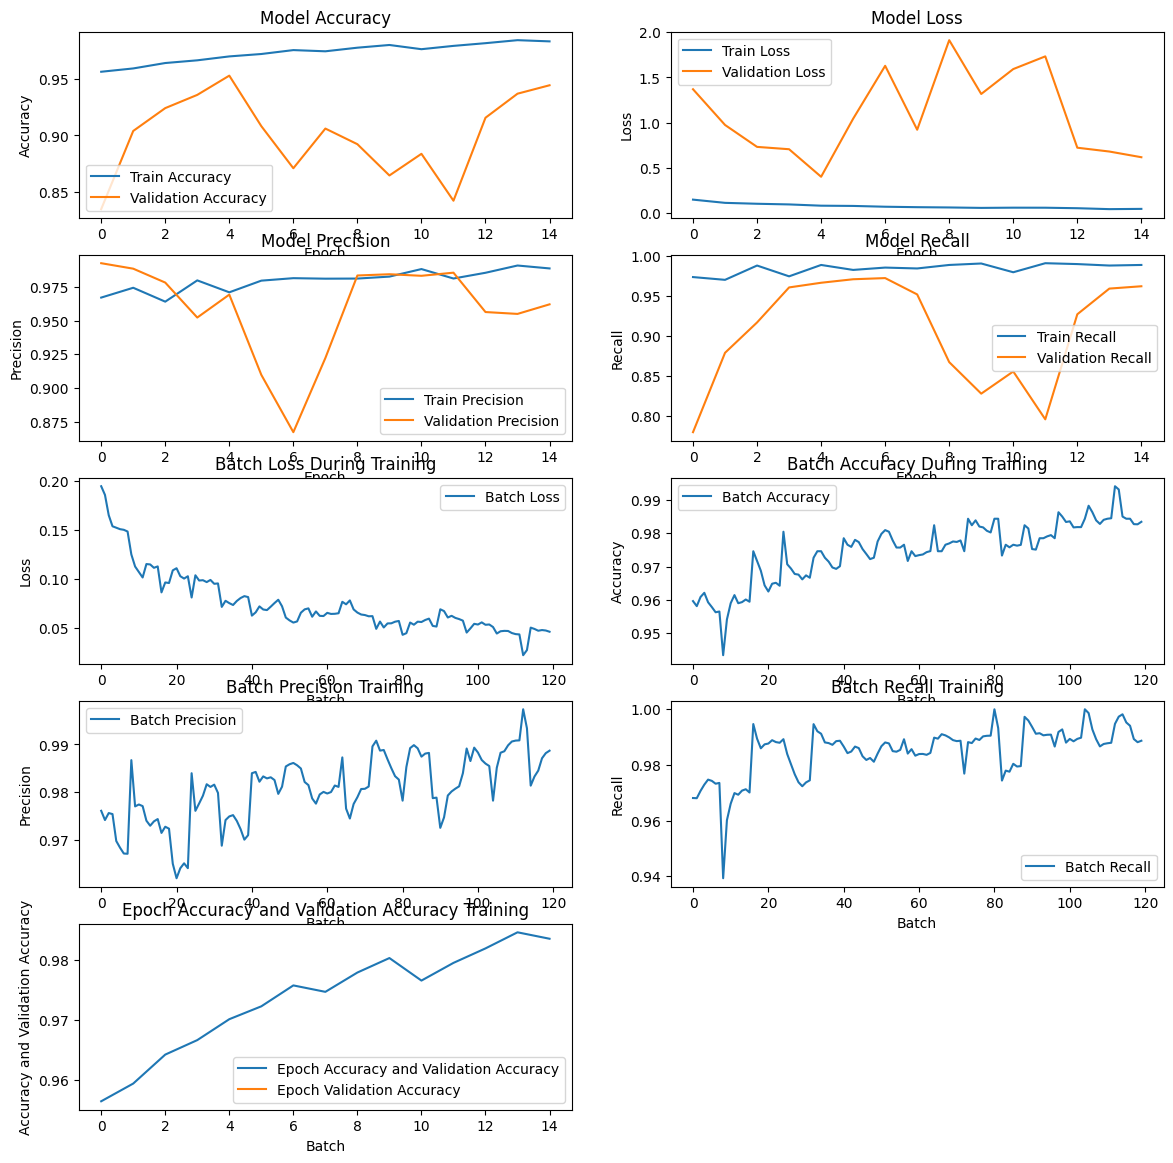

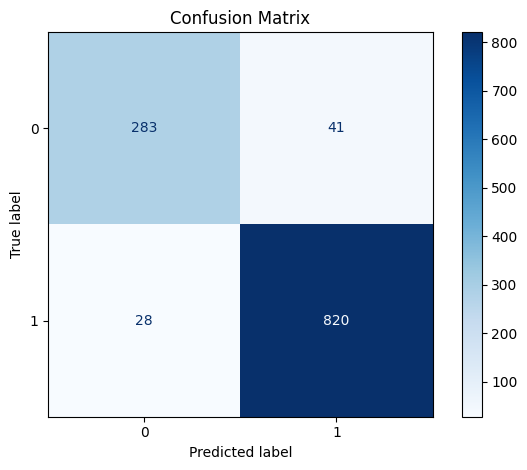

In [31]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,512)

Increase Model Capacity with Data Generation

In [33]:
model = Sequential([
    layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(256, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.SeparableConv2D(512, 3, activation="relu", padding="same"),
    layers.SeparableConv2D(512, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dense(1024, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.7),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation="relu"),
    layers.BatchNormalization(),

    layers.Dense(1, activation="sigmoid")
])


In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy', metrics=METRICS)

Epoch 1/100
19/19 [==============================] - 55s 2s/step - loss: 0.6450 - binary_accuracy: 0.6490 - precision: 0.7677 - recall: 0.7457 - val_loss: 0.6815 - val_binary_accuracy: 0.7235 - val_precision: 0.7235 - val_recall: 1.0000
Epoch 2/100
19/19 [==============================] - 29s 2s/step - loss: 0.3872 - binary_accuracy: 0.8305 - precision: 0.8738 - recall: 0.8978 - val_loss: 0.6381 - val_binary_accuracy: 0.6348 - val_precision: 0.7165 - val_recall: 0.8196
Epoch 3/100
19/19 [==============================] - 30s 2s/step - loss: 0.2945 - binary_accuracy: 0.8770 - precision: 0.9067 - recall: 0.9273 - val_loss: 1.4198 - val_binary_accuracy: 0.7235 - val_precision: 0.7235 - val_recall: 1.0000
Epoch 4/100
19/19 [==============================] - 29s 1s/step - loss: 0.2751 - binary_accuracy: 0.8896 - precision: 0.9178 - recall: 0.9326 - val_loss: 1.4387 - val_binary_accuracy: 0.7090 - val_precision: 0.7202 - val_recall: 0.9776
Epoch 5/100
19/19 [==============================] -

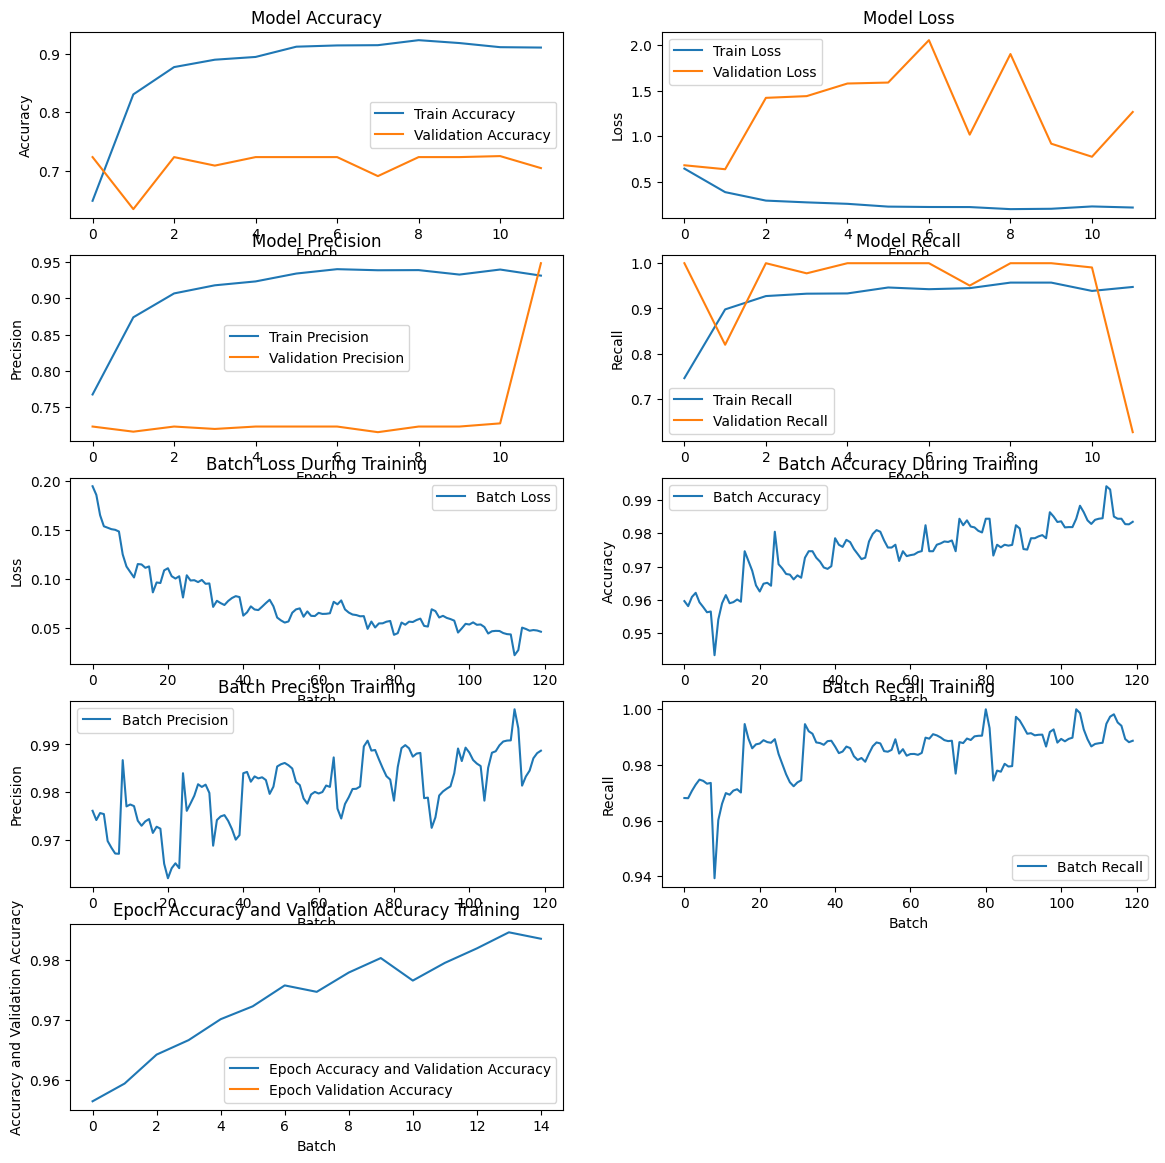

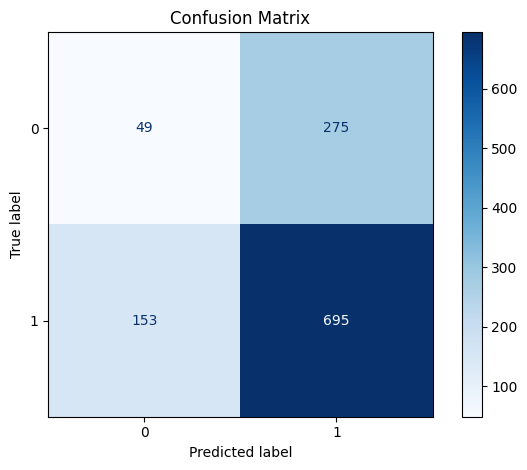

In [36]:
#lr 0.010 model without last dropout,base callbacks
fitModelAndPlot(model,X_train,y_train,X_test,y_test,100,256,useDataGeneration=True)